## Model A — Static DELTA model (component amplitude shift)

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
ROOT = Path("/Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA")
RESULTS = ROOT  # if the csv files are directly here
TC_DIR = ROOT / "timecourses"  # folder with subject timecourses

INDEX_CSV = ROOT / "timecourses_index_K20.csv"  # adjust if filename differs
MANIFEST_CSV = ROOT / "manifest_runs_K20.csv"  
EV_CSV = ROOT / "group_pca_K20_explained_variance_summary.csv"  

print("ROOT:", ROOT)
print("TC_DIR exists?", TC_DIR.exists())
print("INDEX_CSV exists?", INDEX_CSV.exists())

ROOT: /Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA
TC_DIR exists? True
INDEX_CSV exists? True


In [3]:
idx = pd.read_csv(INDEX_CSV)
idx.head()

,subject,task,file,n_timepoints,timecourses_npy,timecourses_csv
0,sub-01,compL1,/anvil/scratch/x-onarayanamud/PreprosessedData...,558,/home/x-onarayanamud/NewPCA/results/result1/ti...,/home/x-onarayanamud/NewPCA/results/result1/ti...
1,sub-01,compLn,/anvil/scratch/x-onarayanamud/PreprosessedData...,558,/home/x-onarayanamud/NewPCA/results/result1/ti...,/home/x-onarayanamud/NewPCA/results/result1/ti...
2,sub-02,compL1,/anvil/scratch/x-onarayanamud/PreprosessedData...,558,/home/x-onarayanamud/NewPCA/results/result1/ti...,/home/x-onarayanamud/NewPCA/results/result1/ti...
3,sub-02,compLn,/anvil/scratch/x-onarayanamud/PreprosessedData...,558,/home/x-onarayanamud/NewPCA/results/result1/ti...,/home/x-onarayanamud/NewPCA/results/result1/ti...
4,sub-03,compL1,/anvil/scratch/x-onarayanamud/PreprosessedData...,558,/home/x-onarayanamud/NewPCA/results/result1/ti...,/home/x-onarayanamud/NewPCA/results/result1/ti...


In [4]:
idx.columns

Index(['subject', 'task', 'file', 'n_timepoints', 'timecourses_npy',
       'timecourses_csv'],
      dtype='object')

In [5]:
idx.groupby(["subject", "task"]).size().unstack(fill_value=0).head(10)

task,compL1,compLn
subject,,
sub-01,1,1
sub-02,1,1
sub-03,1,1
sub-04,1,1
sub-05,1,1
sub-06,1,1
sub-07,1,1
sub-09,1,1
sub-10,1,1


In [6]:
def load_timecourse_csv(csv_path):
    df = pd.read_csv(csv_path)
    X = df.values.astype(np.float32)  # (T, 20)
    return X

data = {}  # data[subject][task] = (T, 20) array

for _, row in idx.iterrows():
    sub = row["subject"]
    task = row["task"]
    csv_path = Path(row["timecourses_csv"]) if "timecourses_csv" in idx.columns else None

    # If the index file doesn't store full paths, build it:
    if csv_path is None or not csv_path.exists():
        csv_path = TC_DIR / f"{sub}_task-{task}_PCsK20.csv"

    if not csv_path.exists():
        print("[MISSING]", csv_path)
        continue

    X = load_timecourse_csv(csv_path)

    data.setdefault(sub, {})
    data[sub][task] = X

print("Subjects loaded:", len(data))
print("Example subject keys:", list(data.keys())[:5])
print("Example tasks for sub-01:", data.get("sub-01", {}).keys())

Subjects loaded: 26
Example subject keys: ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05']
Example tasks for sub-01: dict_keys(['compL1', 'compLn'])


In [7]:
for sub in list(data.keys())[:3]:
    for task in data[sub]:
        print(sub, task, data[sub][task].shape)

sub-01 compL1 (558, 20)
sub-01 compLn (558, 20)
sub-02 compL1 (558, 20)
sub-02 compLn (558, 20)
sub-03 compL1 (558, 20)
sub-03 compLn (558, 20)


In [8]:
def zscore_timecourses(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    return (X - mu) / sd

data_z = {}
for sub in data:
    data_z[sub] = {}
    for task, X in data[sub].items():
        data_z[sub][task] = zscore_timecourses(X)

# Verify
sub = list(data_z.keys())[0]
print(sub, "compL1 mean (first 5 PCs):", data_z[sub]["compL1"].mean(axis=0)[:5])
print(sub, "compL1 std  (first 5 PCs):", data_z[sub]["compL1"].std(axis=0)[:5])

sub-01 compL1 mean (first 5 PCs): [ 3.4181875e-09 -5.1272813e-09 -5.1272813e-09  5.9818284e-09
  8.5454692e-09]
sub-01 compL1 std  (first 5 PCs): [0.99999994 1.         1.         1.         1.0000001 ]


In [9]:
def static_features(X, prefix):
    """
    X: (T, K)
    returns dict of features:
      prefix_PC01_mean, prefix_PC01_std, ...
    """
    feats = {}
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    K = X.shape[1]
    for k in range(K):
        feats[f"{prefix}_PC{(k+1):02d}_mean"] = float(mu[k])
        feats[f"{prefix}_PC{(k+1):02d}_std"]  = float(sd[k])
    return feats

rows = []
missing = []

for sub in sorted(data_z.keys()):
    if "compL1" not in data_z[sub] or "compLn" not in data_z[sub]:
        missing.append(sub)
        continue

    X1 = data_z[sub]["compL1"]
    X2 = data_z[sub]["compLn"]

    f1 = static_features(X1, "L1")
    f2 = static_features(X2, "Ln")

    # Delta features: Ln - L1
    delta = {}
    for k in range(X1.shape[1]):
        delta[f"DELTA_PC{(k+1):02d}_mean"] = f2[f"Ln_PC{(k+1):02d}_mean"] - f1[f"L1_PC{(k+1):02d}_mean"]
        delta[f"DELTA_PC{(k+1):02d}_std"]  = f2[f"Ln_PC{(k+1):02d}_std"]  - f1[f"L1_PC{(k+1):02d}_std"]

    row = {"subject": sub}
    row.update(f1)
    row.update(f2)
    row.update(delta)
    rows.append(row)

features_static = pd.DataFrame(rows).set_index("subject")
print("Feature table shape:", features_static.shape)
print("Missing subjects (no L1 or Ln):", missing)
features_static.head()

Feature table shape: (26, 120)
Missing subjects (no L1 or Ln): []


,L1_PC01_mean,L1_PC01_std,L1_PC02_mean,L1_PC02_std,L1_PC03_mean,L1_PC03_std,L1_PC04_mean,L1_PC04_std,L1_PC05_mean,L1_PC05_std,...,DELTA_PC16_mean,DELTA_PC16_std,DELTA_PC17_mean,DELTA_PC17_std,DELTA_PC18_mean,DELTA_PC18_std,DELTA_PC19_mean,DELTA_PC19_std,DELTA_PC20_mean,DELTA_PC20_std
subject,,,,,,,,,,,,,,,,,,,,,
sub-01,3.418188e-09,1.0,-5.127281e-09,1.0,-5.127281e-09,1.0,5.981828e-09,1.0,8.545469e-09,1.0,...,1.495457e-09,0.000000e+00,-5.981828e-09,0.0,-8.972742e-09,0.000000e+00,-1.089547e-08,0.000000e+00,-6.409102e-09,0.000000e+00
sub-02,-1.025456e-08,1.0,3.418188e-09,1.0,-4.272734e-10,1.0,-8.545469e-10,1.0,1.709094e-09,1.0,...,9.400016e-09,0.000000e+00,0.000000e+00,0.0,5.127281e-09,0.000000e+00,1.367275e-08,0.000000e+00,4.272735e-09,0.000000e+00
sub-03,-8.545469e-10,1.0,0.000000e+00,1.0,-2.136367e-10,1.0,1.709094e-09,1.0,6.836375e-09,1.0,...,-5.981828e-09,0.000000e+00,-1.709094e-09,0.0,-1.281820e-08,-5.960464e-08,8.545469e-10,5.960464e-08,5.981828e-09,0.000000e+00
sub-04,-3.418188e-09,1.0,-5.981828e-09,1.0,1.709094e-09,1.0,-1.709094e-09,1.0,-2.563641e-09,1.0,...,-3.418188e-09,0.000000e+00,2.990914e-09,0.0,4.272734e-10,1.192093e-07,7.690922e-09,5.960464e-08,-8.545469e-09,0.000000e+00
sub-05,3.418188e-09,1.0,-5.127281e-09,1.0,0.000000e+00,1.0,-5.127281e-09,1.0,3.418188e-09,1.0,...,0.000000e+00,5.960464e-08,-1.538184e-08,0.0,7.690922e-09,0.000000e+00,-5.127281e-09,0.000000e+00,8.118195e-09,-1.192093e-07


In [10]:
features_static.to_csv(ROOT / "features_static_L1_Ln_delta.csv")

In [11]:
def corr_features(X, prefix):
    """
    X: (T, K)
    returns flattened upper-triangle correlation features
    """
    C = np.corrcoef(X, rowvar=False)  # (K,K)
    K = C.shape[0]
    feats = {}
    for i in range(K):
        for j in range(i+1, K):
            feats[f"{prefix}_corr_PC{(i+1):02d}_PC{(j+1):02d}"] = float(C[i, j])
    return feats

rows = []
for sub in sorted(data_z.keys()):
    if "compL1" not in data_z[sub] or "compLn" not in data_z[sub]:
        continue

    X1 = data_z[sub]["compL1"]
    X2 = data_z[sub]["compLn"]

    f1 = corr_features(X1, "L1")
    f2 = corr_features(X2, "Ln")

    delta = {}
    for key in f1:
        # key pattern: L1_corr_... ; create matching Ln_corr_...
        ln_key = key.replace("L1_", "Ln_")
        delta[key.replace("L1_", "DELTA_")] = f2[ln_key] - f1[key]

    row = {"subject": sub}
    row.update(f1)
    row.update(f2)
    row.update(delta)
    rows.append(row)

features_conn = pd.DataFrame(rows).set_index("subject")
print("Connectivity features shape:", features_conn.shape)
features_conn.head()

Connectivity features shape: (26, 570)


,L1_corr_PC01_PC02,L1_corr_PC01_PC03,L1_corr_PC01_PC04,L1_corr_PC01_PC05,L1_corr_PC01_PC06,L1_corr_PC01_PC07,L1_corr_PC01_PC08,L1_corr_PC01_PC09,L1_corr_PC01_PC10,L1_corr_PC01_PC11,...,DELTA_corr_PC16_PC17,DELTA_corr_PC16_PC18,DELTA_corr_PC16_PC19,DELTA_corr_PC16_PC20,DELTA_corr_PC17_PC18,DELTA_corr_PC17_PC19,DELTA_corr_PC17_PC20,DELTA_corr_PC18_PC19,DELTA_corr_PC18_PC20,DELTA_corr_PC19_PC20
subject,,,,,,,,,,,,,,,,,,,,,
sub-01,0.018533,-0.091022,0.313323,0.322599,-0.063101,-0.070546,-0.636349,0.081272,-0.394109,-0.523073,...,-0.106038,0.080099,0.426630,0.100887,0.102593,0.016493,0.039515,-0.269685,-0.115132,0.401963
sub-02,-0.122831,-0.626892,0.509882,0.166216,0.378964,-0.140844,-0.463868,-0.176543,-0.191444,-0.493168,...,0.243304,-0.020366,0.251625,0.000108,-0.161910,0.262893,-0.112094,-0.121271,-0.184321,0.006386
sub-03,-0.657223,0.112488,0.800036,0.448391,0.495291,-0.521978,-0.426051,-0.662510,-0.359585,-0.845498,...,-0.123966,0.011216,0.122364,0.060571,0.238518,0.226141,0.076993,-0.234077,-0.062513,0.099669
sub-04,-0.318866,0.078233,0.604484,0.546030,-0.428441,-0.615517,-0.495751,0.233873,-0.408734,-0.350522,...,-0.314637,-0.371934,0.103291,-0.423055,0.023563,-0.146256,-0.198988,0.269330,0.222457,0.289706
sub-05,-0.553725,-0.020486,0.778399,0.388249,0.514987,-0.552740,-0.764496,-0.323889,-0.368991,-0.569712,...,0.136172,-0.054415,0.165307,0.305042,-0.201745,0.111845,-0.043133,0.071797,-0.244235,0.321928


In [12]:
features_conn.to_csv(ROOT / "features_connectivity_L1_Ln_delta.csv")

In [13]:
LABELS_CSV = ROOT / "proficiency_labels.csv"
labels = pd.read_csv(LABELS_CSV).set_index("subject")
labels["y"] = (labels["group"].str.lower() == "advanced").astype(int)  # advanced=1, intermediate=0
labels.head()

,group,y
subject,,
sub-01,advanced,1
sub-02,advanced,1
sub-03,advanced,1
sub-04,advanced,1
sub-05,advanced,1


In [14]:
df = features_static.join(labels[["y"]], how="inner")
print("Subjects with labels:", df.shape[0])

# Use only DELTA features first (best scientific interpretation)
X = df.filter(like="DELTA_")
y = df["y"].values
print("X shape:", X.shape)

Subjects with labels: 26
X shape: (26, 40)


In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="liblinear", max_iter=500))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
bal = cross_val_score(pipe, X, y, cv=cv, scoring="balanced_accuracy")

print("Accuracy:", acc.mean(), "+/-", acc.std())
print("Balanced Acc:", bal.mean(), "+/-", bal.std())

Accuracy: 0.6266666666666667 +/- 0.248014336503177
Balanced Acc: 0.6333333333333333 +/- 0.26666666666666666


In [16]:
pipe.fit(X, y)
coef = pipe.named_steps["clf"].coef_[0]
feat_weights = pd.Series(coef, index=X.columns).sort_values()

print("Top features pushing INTERMEDIATE (negative):")
print(feat_weights.head(10))

print("\nTop features pushing ADVANCED (positive):")
print(feat_weights.tail(10))

Top features pushing INTERMEDIATE (negative):
DELTA_PC05_std    -0.732745
DELTA_PC18_mean   -0.671547
DELTA_PC07_std    -0.586733
DELTA_PC17_std    -0.498660
DELTA_PC06_std    -0.413945
DELTA_PC20_std    -0.390215
DELTA_PC04_mean   -0.374108
DELTA_PC02_mean   -0.336595
DELTA_PC08_std    -0.328367
DELTA_PC16_mean   -0.320692
dtype: float64

Top features pushing ADVANCED (positive):
DELTA_PC20_mean    0.251100
DELTA_PC12_std     0.277142
DELTA_PC02_std     0.308731
DELTA_PC16_std     0.316635
DELTA_PC19_std     0.338864
DELTA_PC11_mean    0.388638
DELTA_PC19_mean    0.412817
DELTA_PC10_std     0.448528
DELTA_PC06_mean    0.475115
DELTA_PC07_mean    0.698274
dtype: float64


## Model B - Connectivity DELTA model (component–component coupling shift) (Also included Model A and Model C)

In [17]:
import numpy as np
import pandas as pd
from pathlib import Path

ROOT = Path("/Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA")

STATIC_CSV = ROOT / "features_static_L1_Ln_delta.csv"
CONN_CSV   = ROOT / "features_connectivity_L1_Ln_delta.csv"  
LABELS_CSV = ROOT / "proficiency_labels.csv"

print("STATIC exists:", STATIC_CSV.exists())
print("CONN exists:", CONN_CSV.exists())
print("LABELS exists:", LABELS_CSV.exists())

feat_static = pd.read_csv(STATIC_CSV).set_index("subject")
feat_conn   = pd.read_csv(CONN_CSV).set_index("subject")
labels      = pd.read_csv(LABELS_CSV).set_index("subject")

# binary target: advanced=1, intermediate=0
labels["y"] = (labels["group"].str.lower() == "advanced").astype(int)

print("Static shape:", feat_static.shape)
print("Conn shape:", feat_conn.shape)
print("Labels shape:", labels.shape)

labels.head()

STATIC exists: True
CONN exists: True
LABELS exists: True
Static shape: (26, 120)
Conn shape: (26, 570)
Labels shape: (26, 2)


,group,y
subject,,
sub-01,advanced,1
sub-02,advanced,1
sub-03,advanced,1
sub-04,advanced,1
sub-05,advanced,1


In [18]:
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

def eval_model(X, y, cv, model_name="model"):
    """
    Runs CV prediction + computes balanced accuracy and AUC.
    Uses predict_proba for AUC if available.
    """
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty="l2", solver="liblinear", max_iter=2000))
    ])
    
    # cross-validated predicted probabilities
    y_prob = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    bal = balanced_accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    
    print(f"{model_name} -> Balanced Acc = {bal:.4f}, AUC = {auc:.4f}")
    return {"model": model_name, "balanced_acc": bal, "auc": auc}

# Choose CV
# Use 5-fold if you have enough subjects in each group.
# If sample is small, LOOCV is safer.
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
# Merge with labels
df_conn = feat_conn.join(labels[["y"]], how="inner")

# Use only delta connectivity features
X_conn = df_conn.filter(like="DELTA_")
y = df_conn["y"].values

print("X_conn shape:", X_conn.shape, "Subjects:", len(y))

res_conn = eval_model(X_conn, y, cv=cv5, model_name="Connectivity DELTA")
res_conn

X_conn shape: (26, 190) Subjects: 26
Connectivity DELTA -> Balanced Acc = 0.4970, AUC = 0.4909


{'model': 'Connectivity DELTA',
 'balanced_acc': 0.49696969696969695,
 'auc': 0.4909090909090909}

In [20]:
df_static = feat_static.join(labels[["y"]], how="inner")

X_static = df_static.filter(like="DELTA_")
y = df_static["y"].values

# Align indices and combine
X_combined = pd.concat([X_static, X_conn], axis=1).loc[df_static.index]

print("X_static:", X_static.shape)
print("X_conn:", X_conn.shape)
print("X_combined:", X_combined.shape)

res_static = eval_model(X_static, y, cv=cv5, model_name="Static DELTA")
res_combined = eval_model(X_combined, y, cv=cv5, model_name="Combined (Static+Conn) DELTA")

pd.DataFrame([res_static, res_conn, res_combined])

X_static: (26, 40)
X_conn: (26, 190)
X_combined: (26, 230)
Static DELTA -> Balanced Acc = 0.6303, AUC = 0.6848
Combined (Static+Conn) DELTA -> Balanced Acc = 0.6212, AUC = 0.6545


,model,balanced_acc,auc
0,Static DELTA,0.630303,0.684848
1,Connectivity DELTA,0.496970,0.490909
2,Combined (Static+Conn) DELTA,0.621212,0.654545


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="liblinear", max_iter=2000))
])

pipe.fit(X_static, y)
coef = pipe.named_steps["clf"].coef_[0]
weights = pd.Series(coef, index=X_static.columns).sort_values()

print("Top features toward INTERMEDIATE (negative):")
print(weights.head(12))

print("\nTop features toward ADVANCED (positive):")
print(weights.tail(12))

Top features toward INTERMEDIATE (negative):
DELTA_PC05_std    -0.732745
DELTA_PC18_mean   -0.671547
DELTA_PC07_std    -0.586733
DELTA_PC17_std    -0.498660
DELTA_PC06_std    -0.413945
DELTA_PC20_std    -0.390215
DELTA_PC04_mean   -0.374108
DELTA_PC02_mean   -0.336595
DELTA_PC08_std    -0.328367
DELTA_PC16_mean   -0.320692
DELTA_PC15_std    -0.193245
DELTA_PC13_std    -0.187561
dtype: float64

Top features toward ADVANCED (positive):
DELTA_PC10_mean    0.219461
DELTA_PC14_mean    0.228215
DELTA_PC20_mean    0.251100
DELTA_PC12_std     0.277142
DELTA_PC02_std     0.308731
DELTA_PC16_std     0.316635
DELTA_PC19_std     0.338864
DELTA_PC11_mean    0.388638
DELTA_PC19_mean    0.412817
DELTA_PC10_std     0.448528
DELTA_PC06_mean    0.475115
DELTA_PC07_mean    0.698274
dtype: float64


In [22]:
import re

def pc_from_feature_name(name):
    # matches DELTA_PC01_mean, DELTA_PC01_std
    m = re.search(r"DELTA_PC(\d{2})_", name)
    return f"PC{m.group(1)}" if m else None

pc_scores = {}
for feat, w in weights.items():
    pc = pc_from_feature_name(feat)
    if pc is None:
        continue
    pc_scores[pc] = pc_scores.get(pc, 0) + abs(w)

pc_scores = pd.Series(pc_scores).sort_values(ascending=False)
pc_scores.head(10)

PC07    1.285007
PC05    0.908944
PC06    0.889060
PC18    0.832703
PC19    0.751681
PC10    0.667989
PC02    0.645326
PC20    0.641315
PC16    0.637327
PC17    0.624886
dtype: float64

## Model D — Dynamic DELTA model (temporal stability and variability) and Model E — Fully combined model (Static + Connectivity + Dynamic DELTA)

In [23]:
TC_DIR = ROOT / "timecourses"

def load_tc_csv(sub, task, K=20):
    f = TC_DIR / f"{sub}_task-{task}_PCsK{K}.csv"
    df = pd.read_csv(f)
    return df.values.astype(np.float32)

subjects = sorted(labels.index.tolist())
print("Subjects in labels:", len(subjects))
print("Example:", subjects[:5])

Subjects in labels: 26
Example: ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05']


In [24]:
def zscore_run(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    return (X - mu) / sd

def lag1_autocorr(X):
    # X: (T, K), assume already zscored
    # corr(x_t, x_{t-1}) per component
    x0 = X[:-1]
    x1 = X[1:]
    # since zscored, corr is mean(x0*x1)
    return np.mean(x0 * x1, axis=0)

def variability_derivative(X):
    # std of first difference per component
    d = np.diff(X, axis=0)
    return d.std(axis=0)

rows = []

for sub in subjects:
    # Need both L1 and Ln for delta
    try:
        X1 = zscore_run(load_tc_csv(sub, "compL1", K=20))
        X2 = zscore_run(load_tc_csv(sub, "compLn", K=20))
    except FileNotFoundError:
        continue
    
    ac1 = lag1_autocorr(X1)   # (20,)
    ac2 = lag1_autocorr(X2)
    var1 = variability_derivative(X1)
    var2 = variability_derivative(X2)

    row = {"subject": sub}
    for k in range(20):
        row[f"L1_PC{(k+1):02d}_lag1"] = float(ac1[k])
        row[f"Ln_PC{(k+1):02d}_lag1"] = float(ac2[k])
        row[f"DELTA_PC{(k+1):02d}_lag1"] = float(ac2[k] - ac1[k])

        row[f"L1_PC{(k+1):02d}_varD"] = float(var1[k])
        row[f"Ln_PC{(k+1):02d}_varD"] = float(var2[k])
        row[f"DELTA_PC{(k+1):02d}_varD"] = float(var2[k] - var1[k])

    rows.append(row)

features_dyn = pd.DataFrame(rows).set_index("subject")
print("Dynamic feature table shape:", features_dyn.shape)
features_dyn.head()

Dynamic feature table shape: (26, 120)


,L1_PC01_lag1,Ln_PC01_lag1,DELTA_PC01_lag1,L1_PC01_varD,Ln_PC01_varD,DELTA_PC01_varD,L1_PC02_lag1,Ln_PC02_lag1,DELTA_PC02_lag1,L1_PC02_varD,...,DELTA_PC19_lag1,L1_PC19_varD,Ln_PC19_varD,DELTA_PC19_varD,L1_PC20_lag1,Ln_PC20_lag1,DELTA_PC20_lag1,L1_PC20_varD,Ln_PC20_varD,DELTA_PC20_varD
subject,,,,,,,,,,,,,,,,,,,,,
sub-01,0.745480,0.694550,-0.050931,0.713766,0.779194,0.065428,0.697162,0.806182,0.109020,0.776603,...,-0.379531,0.839121,1.206119,0.366998,0.332683,0.037759,-0.294924,1.135737,1.387302,0.251565
sub-02,0.584344,0.630101,0.045757,0.900600,0.853720,-0.046880,0.570547,0.559858,-0.010689,0.927875,...,0.181787,1.168783,1.003464,-0.165318,0.495077,0.595164,0.100087,0.977896,0.878787,-0.099109
sub-03,0.746358,0.806405,0.060047,0.692691,0.617702,-0.074989,0.644024,0.660426,0.016402,0.833824,...,-0.091879,1.033539,1.114990,0.081452,0.561921,0.613603,0.051682,0.914796,0.864017,-0.050779
sub-04,0.720874,0.717029,-0.003845,0.749416,0.751112,0.001696,0.488250,0.574387,0.086136,1.002819,...,0.250719,1.229882,1.016829,-0.213053,0.561440,0.670696,0.109256,0.929937,0.806486,-0.123450
sub-05,0.666948,0.696311,0.029362,0.807314,0.777992,-0.029322,0.482896,0.417314,-0.065582,1.009796,...,-0.026839,0.801175,0.828368,0.027193,0.541280,0.618608,0.077327,0.942871,0.866281,-0.076590


In [25]:
features_dyn.to_csv(ROOT / "features_dynamic_lag1_varD_L1_Ln_delta.csv")

In [26]:
df_dyn = features_dyn.join(labels[["y"]], how="inner")
X_dyn = df_dyn.filter(like="DELTA_")
y_dyn = df_dyn["y"].values

print("X_dyn shape:", X_dyn.shape)

res_dyn = eval_model(X_dyn, y_dyn, cv=cv5, model_name="Dynamic DELTA (lag1 + varD)")
res_dyn

X_dyn shape: (26, 40)
Dynamic DELTA (lag1 + varD) -> Balanced Acc = 0.4152, AUC = 0.3818


{'model': 'Dynamic DELTA (lag1 + varD)',
 'balanced_acc': 0.41515151515151516,
 'auc': 0.38181818181818183}

In [27]:
# Align all feature sets to same subjects
common = df_static.index.intersection(df_conn.index).intersection(df_dyn.index)

X_all = pd.concat([
    X_static.loc[common],
    X_conn.loc[common],
    X_dyn.loc[common],
], axis=1)

y_all = labels.loc[common, "y"].values

print("X_all shape:", X_all.shape, "Subjects:", len(common))

res_all = eval_model(X_all, y_all, cv=cv5, model_name="Combined (Static+Conn+Dyn) DELTA")
res_all

X_all shape: (26, 270) Subjects: 26
Combined (Static+Conn+Dyn) DELTA -> Balanced Acc = 0.5303, AUC = 0.4788


{'model': 'Combined (Static+Conn+Dyn) DELTA',
 'balanced_acc': 0.5303030303030303,
 'auc': 0.4787878787878788}

In [28]:
results = pd.DataFrame([res_static, res_conn, res_combined, res_dyn, res_all])
results

,model,balanced_acc,auc
0,Static DELTA,0.630303,0.684848
1,Connectivity DELTA,0.496970,0.490909
2,Combined (Static+Conn) DELTA,0.621212,0.654545
3,Dynamic DELTA (lag1 + varD),0.415152,0.381818
4,Combined (Static+Conn+Dyn) DELTA,0.530303,0.478788


## Next steps (interpretation and writting)

In [29]:
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

X = X_static  # Static DELTA features
y = y         # labels

loo = LeaveOneOut()

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="liblinear", max_iter=2000))
])

y_prob = cross_val_predict(pipe, X, y, cv=loo, method="predict_proba")[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

bal_acc = balanced_accuracy_score(y, y_pred)
auc = roc_auc_score(y, y_prob)

print("LOOCV Balanced Accuracy:", bal_acc)
print("LOOCV AUC:", auc)

LOOCV Balanced Accuracy: 0.6515151515151515
LOOCV AUC: 0.6303030303030303


In [30]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

n_boot = 1000
coefs = []

for i in range(n_boot):
    X_b, y_b = resample(X, y, replace=True, random_state=i)
    pipe.fit(X_b, y_b)
    coefs.append(pipe.named_steps["clf"].coef_[0])

coef_df = pd.DataFrame(coefs, columns=X.columns)

# Mean and variability of coefficients
coef_mean = coef_df.mean()
coef_std  = coef_df.std()

coef_summary = pd.DataFrame({
    "mean_weight": coef_mean,
    "std_weight": coef_std,
    "abs_mean": coef_mean.abs()
}).sort_values("abs_mean", ascending=False)

coef_summary.head(15)

,mean_weight,std_weight,abs_mean
DELTA_PC07_mean,0.513731,0.118816,0.513731
DELTA_PC05_std,-0.513493,0.163608,0.513493
DELTA_PC18_mean,-0.458366,0.197304,0.458366
DELTA_PC06_mean,0.348606,0.180199,0.348606
DELTA_PC17_std,-0.310628,0.162351,0.310628
DELTA_PC04_mean,-0.306140,0.139251,0.306140
DELTA_PC07_std,-0.301733,0.199181,0.301733
DELTA_PC06_std,-0.298039,0.143353,0.298039
DELTA_PC10_std,0.288567,0.204632,0.288567
DELTA_PC16_mean,-0.277842,0.186809,0.277842


In [ ]:
Statistical confirmation plots

In [31]:
plot_pcs = ["PC07", "PC05", "PC06", "PC18"]

plot_rows = []
for pc in plot_pcs:
    for metric in ["mean", "std"]:
        col = f"DELTA_{pc}_{metric}"
        if col in X.columns:
            tmp = pd.DataFrame({
                "value": X[col],
                "group": labels.loc[X.index, "group"],
                "PC": pc,
                "metric": metric
            })
            plot_rows.append(tmp)

plot_df = pd.concat(plot_rows)
plot_df.head()

,value,group,PC,metric
subject,,,,
sub-01,4.272734e-09,advanced,PC07,mean
sub-02,-5.127281e-09,advanced,PC07,mean
sub-03,-1.709094e-09,advanced,PC07,mean
sub-04,-3.418188e-09,advanced,PC07,mean
sub-05,-1.709094e-09,advanced,PC07,mean


<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


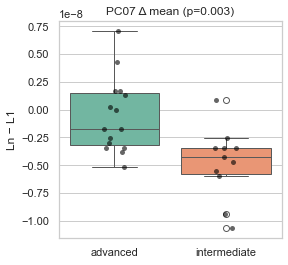

<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


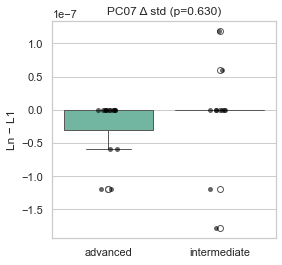

<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


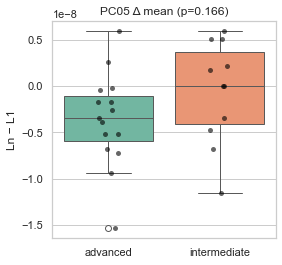

<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


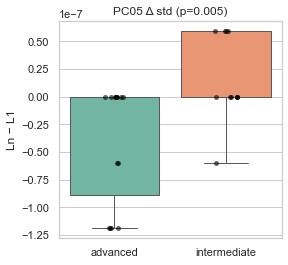

<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


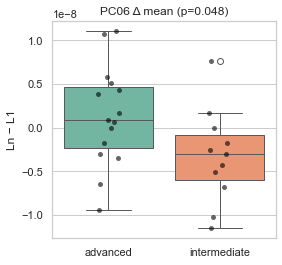

<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


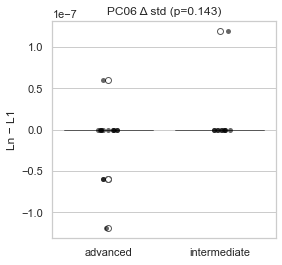

<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


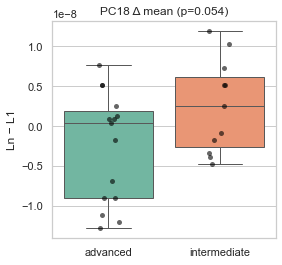

<ipython-input-32-5873b96231eb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sub, x="group", y="value", palette="Set2")


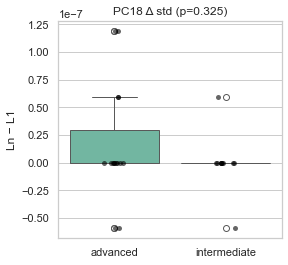

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

sns.set(style="whitegrid")

for pc in plot_pcs:
    for metric in ["mean", "std"]:
        sub = plot_df[(plot_df["PC"] == pc) & (plot_df["metric"] == metric)]
        if len(sub) == 0:
            continue
        
        plt.figure(figsize=(4,4))
        sns.boxplot(data=sub, x="group", y="value", palette="Set2")
        sns.stripplot(data=sub, x="group", y="value", color="black", alpha=0.6)
        
        adv = sub[sub["group"]=="advanced"]["value"]
        inter = sub[sub["group"]=="intermediate"]["value"]
        t,p = ttest_ind(adv, inter, equal_var=False)
        
        plt.title(f"{pc} Δ {metric} (p={p:.3f})")
        plt.ylabel("Ln − L1")
        plt.xlabel("")
        plt.show()

In [33]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.var() + (ny-1)*y.var()) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

for pc in plot_pcs:
    col = f"DELTA_{pc}_mean"
    if col in X.columns:
        adv = X.loc[labels["group"]=="advanced", col]
        inter = X.loc[labels["group"]=="intermediate", col]
        print(pc, "Cohen's d:", cohens_d(adv, inter))

PC07 Cohen's d: 1.2849090735131348
PC05 Cohen's d: -0.5784236941376529
PC06 Cohen's d: 0.8214272025974906
PC18 Cohen's d: -0.7856245550473117


In [34]:
!pip install nilearn nibabel


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [35]:
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib

ROOT = Path("/Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA")

COMP_NII = ROOT / "group_pca_K20_components.nii.gz"
MASK_NII = ROOT / "mask_from_first_run.nii.gz"   # you have this
FIG_DIR  = ROOT / "figures_pca"
FIG_DIR.mkdir(exist_ok=True)

print("COMP exists:", COMP_NII.exists())
print("MASK exists:", MASK_NII.exists())

comp_img = nib.load(str(COMP_NII))
mask_img = nib.load(str(MASK_NII))

comp_data = comp_img.get_fdata(dtype=np.float32)  # (X,Y,Z,K)
mask_data = mask_img.get_fdata().astype(bool)

print("Components shape:", comp_data.shape)
print("Mask voxels:", mask_data.sum())

COMP exists: True
MASK exists: True
Components shape: (91, 109, 91, 20)
Mask voxels: 892725


In [36]:
TOP_PCS = [2, 5, 6, 7, 10, 18, 19]  # using your list
# convert PC numbers (1-based) to volume indices (0-based)
pc_indices = [pc-1 for pc in TOP_PCS]

def zscore_map(vol3d, mask):
    x = vol3d[mask]
    mu = x.mean()
    sd = x.std()
    if sd == 0:
        sd = 1.0
    z = (vol3d - mu) / sd
    z[~mask] = 0
    return z.astype(np.float32)

z_maps = {}
for pc, idx in zip(TOP_PCS, pc_indices):
    z_maps[pc] = zscore_map(comp_data[..., idx], mask_data)

print("Built z-scored maps for PCs:", list(z_maps.keys()))

Built z-scored maps for PCs: [2, 5, 6, 7, 10, 18, 19]


In [37]:
from nilearn import plotting
import matplotlib.pyplot as plt

def save_pc_figures(pc, zvol, bg="MNI152"):
    img = nib.Nifti1Image(zvol, affine=comp_img.affine)
    
    # 1) glass brain (very clean, paper-friendly)
    disp = plotting.plot_glass_brain(
        img, display_mode="lyrz", threshold=2.0,
        colorbar=True, title=f"PCA Component PC{pc:02d} (|z|>=2)"
    )
    out1 = FIG_DIR / f"PC{pc:02d}_glass.png"
    disp.savefig(str(out1), dpi=300)
    disp.close()
    
    # 2) stat map (orthogonal slices)
    disp2 = plotting.plot_stat_map(
        img, display_mode="ortho", threshold=2.0,
        colorbar=True, title=f"PC{pc:02d} (|z|>=2)"
    )
    out2 = FIG_DIR / f"PC{pc:02d}_ortho.png"
    disp2.savefig(str(out2), dpi=300)
    disp2.close()

for pc in TOP_PCS:
    save_pc_figures(pc, z_maps[pc])

print("Saved figures to:", FIG_DIR)

Saved figures to: /Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA/figures_pca


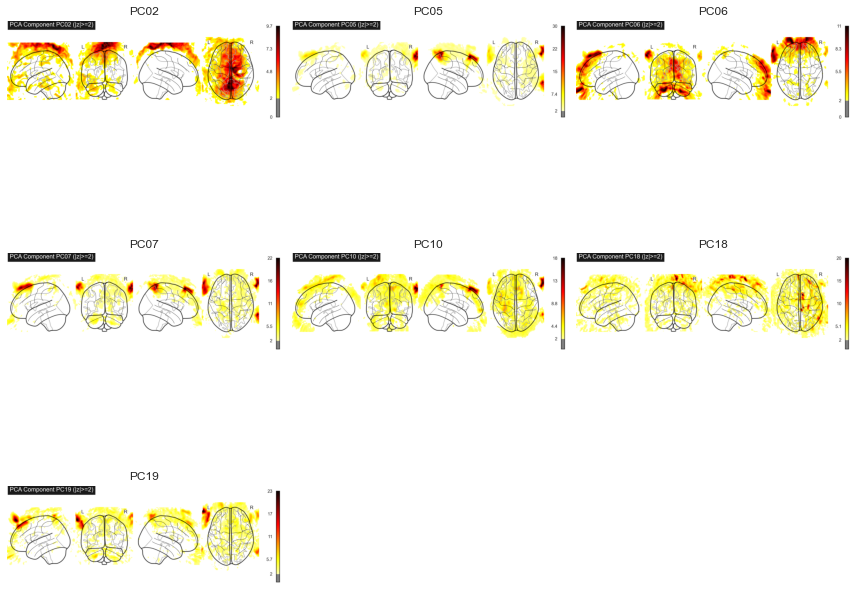

Saved panel: /Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA/figures_pca/PCA_top_PCs_panel.png


In [38]:
import matplotlib.pyplot as plt
from PIL import Image

panel_files = [FIG_DIR / f"PC{pc:02d}_glass.png" for pc in TOP_PCS]

n = len(panel_files)
cols = 3
rows = int(np.ceil(n / cols))

plt.figure(figsize=(cols*4, rows*3.5))
for i, f in enumerate(panel_files):
    img = Image.open(f)
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f.stem.replace("_glass",""), fontsize=12)
plt.tight_layout()

panel_out = FIG_DIR / "PCA_top_PCs_panel.png"
plt.savefig(panel_out, dpi=300, bbox_inches="tight")
plt.show()

print("Saved panel:", panel_out)

In [39]:
from nilearn import datasets, image
from scipy.stats import pearsonr

# Fetch Yeo atlas (requires internet once; after that it caches)
yeo = datasets.fetch_atlas_yeo_2011()
# Use 7-network or 17-network atlas:
yeo7_img = nib.load(yeo.thick_7)   # 3D labels
yeo17_img = nib.load(yeo.thick_17) # 3D labels

print("Yeo 7 atlas:", yeo.thick_7)
print("Yeo 17 atlas:", yeo.thick_17)

[get_dataset_dir] Dataset found in /Users/onilarasanjala/nilearn_data/yeo_2011

Yeo 7 atlas: /Users/onilarasanjala/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Yeo 17 atlas: /Users/onilarasanjala/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz


In [40]:
def map_pc_to_yeo(pc_zimg, yeo_label_img, mask_img, n_labels):
    """
    pc_zimg: Nifti1Image (z-scored component map)
    yeo_label_img: Nifti1Image with integer labels
    mask_img: Nifti1Image (brain mask)
    n_labels: number of networks (7 or 17)
    Returns: dict label -> correlation / mean(|z|) in network
    """
    # resample yeo to PCA image grid
    yeo_rs = image.resample_to_img(yeo_label_img, pc_zimg, interpolation="nearest")
    yeo_data = yeo_rs.get_fdata().astype(int)
    mask = mask_img.get_fdata().astype(bool)
    
    z = pc_zimg.get_fdata()
    z = z[mask]
    y = yeo_data[mask]
    
    out = []
    for lab in range(1, n_labels+1):
        sel = (y == lab)
        if sel.sum() < 10:
            out.append((lab, np.nan, np.nan))
            continue
        # correlation between z and binary membership (simple, interpretable)
        binv = sel.astype(float)
        r = pearsonr(z, binv)[0]
        mean_abs = np.mean(np.abs(z[sel]))
        out.append((lab, r, mean_abs))
    
    df = pd.DataFrame(out, columns=["yeo_label", "corr_with_membership", "mean_abs_z_in_label"])
    df = df.sort_values("mean_abs_z_in_label", ascending=False)
    return df

# Build NIfTI images for PCs
pc_imgs = {pc: nib.Nifti1Image(z_maps[pc], comp_img.affine) for pc in TOP_PCS}

yeo7_maps = {}
for pc in TOP_PCS:
    yeo7_maps[pc] = map_pc_to_yeo(pc_imgs[pc], yeo7_img, mask_img, n_labels=7)

yeo7_maps[7].head(7)

<ipython-input-40-886243fec941>:10: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  yeo_rs = image.resample_to_img(yeo_label_img, pc_zimg, interpolation="nearest")
/Users/onilarasanjala/mambaforge/envs/pytorch/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
mapping_rows = []
for pc in TOP_PCS:
    df = yeo7_maps[pc].copy()
    top1 = df.iloc[0]
    top2 = df.iloc[1]
    mapping_rows.append({
        "PC": f"PC{pc:02d}",
        "Top_Yeo7_Label_1": int(top1["yeo_label"]),
        "Top1_mean_abs_z": float(top1["mean_abs_z_in_label"]),
        "Top_Yeo7_Label_2": int(top2["yeo_label"]),
        "Top2_mean_abs_z": float(top2["mean_abs_z_in_label"]),
    })

pc_to_yeo7 = pd.DataFrame(mapping_rows)
pc_to_yeo7

In [43]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image
from nilearn import datasets

# Load Yeo7
yeo = datasets.fetch_atlas_yeo_2011()
yeo7_img = nib.load(yeo.thick_7)

def map_pc_to_yeo7(pc_img, mask_img, yeo7_img, n_labels=7):
    """
    Robust mapping of PCA component map -> Yeo7 networks.
    Uses:
      - mean_abs_z within each label (primary)
      - signed mean_z within each label (secondary, direction)
      - optional membership correlation (safe version)
    """
    # Resample atlas into PCA space
    yeo_rs = image.resample_to_img(
        yeo7_img, pc_img,
        interpolation="nearest",
        force_resample=True,
        copy_header=True
    )
    
    z3 = pc_img.get_fdata().astype(np.float64)
    m3 = mask_img.get_fdata().astype(bool)
    y3 = yeo_rs.get_fdata().astype(np.int16)

    # Apply mask and clean
    z = z3[m3].astype(np.float64)
    y = y3[m3].astype(np.int16)

    good = np.isfinite(z)
    z = z[good]
    y = y[good]

    out = []
    for lab in range(1, n_labels + 1):
        sel = (y == lab)
        n = int(sel.sum())
        if n < 50:
            out.append((lab, n, np.nan, np.nan, np.nan))
            continue
        
        z_lab = z[sel]
        mean_abs = float(np.mean(np.abs(z_lab)))
        mean_signed = float(np.mean(z_lab))
        
        # "membership correlation" (safe):
        # corr(z, 1[label]) computed manually with variance checks
        binv = sel.astype(np.float64)
        zc = z - z.mean()
        bc = binv - binv.mean()
        denom = np.sqrt((zc**2).sum() * (bc**2).sum())
        r = float((zc * bc).sum() / denom) if denom > 0 else np.nan

        out.append((lab, n, mean_abs, mean_signed, r))

    df = pd.DataFrame(out, columns=[
        "yeo7_label", "n_vox", "mean_abs_z", "mean_signed_z", "membership_corr"
    ]).sort_values("mean_abs_z", ascending=False)

    return df

[get_dataset_dir] Dataset found in /Users/onilarasanjala/nilearn_data/yeo_2011

In [44]:
from pathlib import Path

ROOT = Path("/Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA")
COMP_NII = ROOT / "group_pca_K20_components.nii.gz"
MASK_NII = ROOT / "mask_from_first_run.nii.gz"

comp_img = nib.load(str(COMP_NII))
mask_img = nib.load(str(MASK_NII))

TOP_PCS = [2, 5, 6, 7, 10, 18, 19]   # your choice
pc_imgs = {}

# Make z-scored PC images again (recommended)
comp_data = comp_img.get_fdata(dtype=np.float32)
mask_data = mask_img.get_fdata().astype(bool)

def zscore_map(vol3d, mask):
    x = vol3d[mask].astype(np.float64)
    mu = x.mean()
    sd = x.std()
    if sd == 0:
        sd = 1.0
    z = (vol3d.astype(np.float64) - mu) / sd
    z[~mask] = 0
    return z.astype(np.float32)

for pc in TOP_PCS:
    idx = pc - 1
    zvol = zscore_map(comp_data[..., idx], mask_data)
    pc_imgs[pc] = nib.Nifti1Image(zvol, affine=comp_img.affine)

yeo7_maps = {}
for pc in TOP_PCS:
    yeo7_maps[pc] = map_pc_to_yeo7(pc_imgs[pc], mask_img, yeo7_img, n_labels=7)
    print(f"\nPC{pc:02d} top Yeo7 matches:")
    display(yeo7_maps[pc].head(3))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

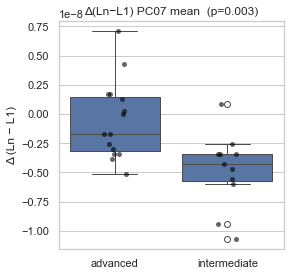

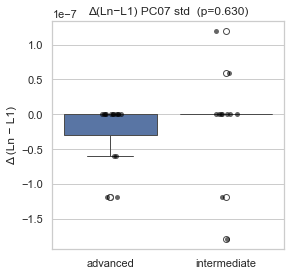

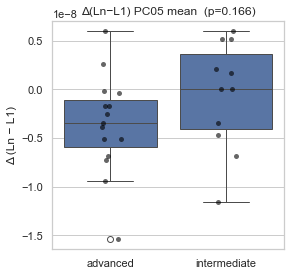

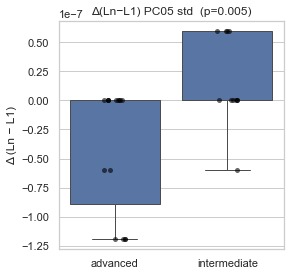

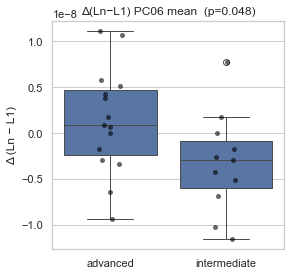

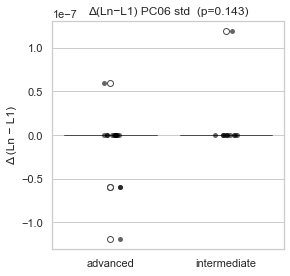

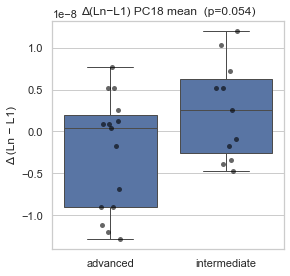

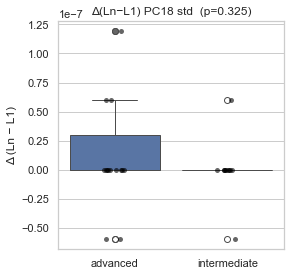

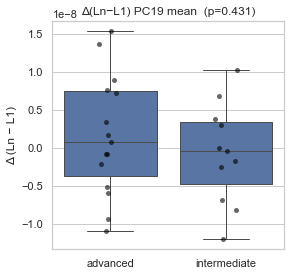

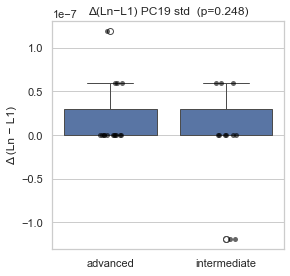

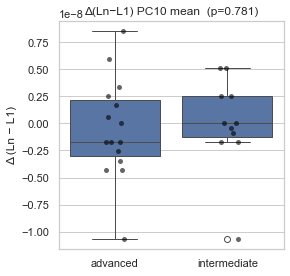

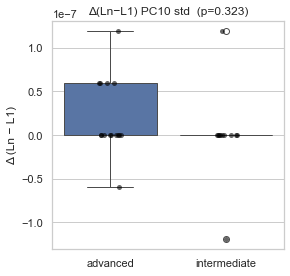

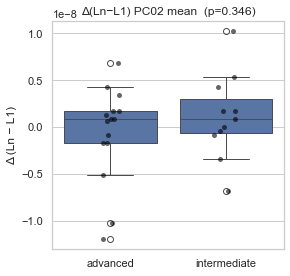

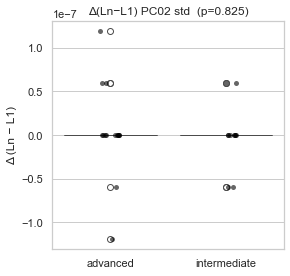

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

STATIC_CSV = ROOT / "features_static_L1_Ln_delta.csv"
LABELS_CSV = ROOT / "proficiency_labels.csv"

feat_static = pd.read_csv(STATIC_CSV).set_index("subject")
labels = pd.read_csv(LABELS_CSV).set_index("subject")
labels["group"] = labels["group"].str.lower()

df = feat_static.join(labels[["group"]], how="inner")

pcs_for_effect = ["07","05","06","18","19","10","02"]  # as strings
metrics = ["mean","std"]

sns.set(style="whitegrid")

for pc in pcs_for_effect:
    for metric in metrics:
        col = f"DELTA_PC{pc}_{metric}"
        if col not in df.columns:
            continue
        
        plt.figure(figsize=(4.2, 4))
        tmp = df[[col, "group"]].dropna().rename(columns={col: "delta"})
        
        sns.boxplot(data=tmp, x="group", y="delta")
        sns.stripplot(data=tmp, x="group", y="delta", color="black", alpha=0.6)
        
        adv = tmp[tmp["group"]=="advanced"]["delta"]
        inter = tmp[tmp["group"]=="intermediate"]["delta"]
        t,p = ttest_ind(adv, inter, equal_var=False)
        
        plt.title(f"Δ(Ln−L1) PC{pc} {metric}  (p={p:.3f})")
        plt.ylabel("Δ (Ln − L1)")
        plt.xlabel("")
        plt.tight_layout()
        
        out = FIG_DIR / f"effect_PC{pc}_{metric}.png"
        plt.savefig(out, dpi=300, bbox_inches="tight")
        plt.show()

KMeans ARI vs true labels: -0.00449564484405732
Silhouette score: 0.14345705884064966


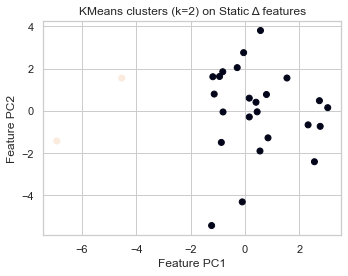

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA as skPCA

# Use only DELTA features
Xdelta = df.filter(like="DELTA_").dropna()
y_true = (df.loc[Xdelta.index, "group"] == "advanced").astype(int).values

Xz = StandardScaler().fit_transform(Xdelta.values)

# KMeans with k=2
km = KMeans(n_clusters=2, random_state=42, n_init=50)
cl = km.fit_predict(Xz)

ari = adjusted_rand_score(y_true, cl)
sil = silhouette_score(Xz, cl)

print("KMeans ARI vs true labels:", ari)
print("Silhouette score:", sil)

# Visualize in 2D feature PCA space
X2 = skPCA(n_components=2, random_state=42).fit_transform(Xz)
plt.figure(figsize=(5,4))
plt.scatter(X2[:,0], X2[:,1], c=cl)
plt.title("KMeans clusters (k=2) on Static Δ features")
plt.xlabel("Feature PC1")
plt.ylabel("Feature PC2")
plt.tight_layout()
plt.show()

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

STATIC_CSV = ROOT / "features_static_L1_Ln_delta.csv"
LABELS_CSV = ROOT / "proficiency_labels.csv"

feat_static = pd.read_csv(STATIC_CSV).set_index("subject")
labels = pd.read_csv(LABELS_CSV).set_index("subject")
labels["group"] = labels["group"].str.lower()
labels["y"] = (labels["group"] == "advanced").astype(int)

df = feat_static.join(labels[["group", "y"]], how="inner")
X = df.filter(like="DELTA_")     # use only delta features
y_true = df["y"].values

Xz = StandardScaler().fit_transform(X.values)
print("X shape:", X.shape)
print(df["group"].value_counts())

X shape: (26, 40)
group
advanced        15
intermediate    11
Name: count, dtype: int64


In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

km = KMeans(n_clusters=2, random_state=42, n_init=50)
cl = km.fit_predict(Xz)

ari = adjusted_rand_score(y_true, cl)
nmi = normalized_mutual_info_score(y_true, cl)
sil = silhouette_score(Xz, cl)

print("KMeans ARI:", ari)
print("KMeans NMI:", nmi)
print("Silhouette:", sil)

KMeans ARI: -0.00449564484405732
KMeans NMI: 0.002097916479456781
Silhouette: 0.14345705884064966


In [47]:
from sklearn.metrics import confusion_matrix

cm0 = confusion_matrix(y_true, cl)
cm1 = confusion_matrix(y_true, 1 - cl)

# pick the alignment that gives higher diagonal sum
if np.trace(cm1) > np.trace(cm0):
    cl_aligned = 1 - cl
else:
    cl_aligned = cl

cm = confusion_matrix(y_true, cl_aligned)
print("Confusion matrix (rows=true y, cols=cluster-aligned):\n", cm)

acc = (cm[0,0] + cm[1,1]) / cm.sum()
print("Cluster-aligned accuracy:", acc)

Confusion matrix (rows=true y, cols=cluster-aligned):
 [[ 1 10]
 [ 1 14]]
Cluster-aligned accuracy: 0.5769230769230769


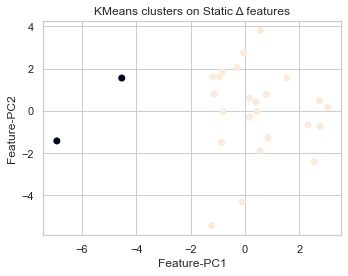

In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X2 = PCA(n_components=2, random_state=42).fit_transform(Xz)

plt.figure(figsize=(5,4))
plt.scatter(X2[:,0], X2[:,1], c=cl_aligned)
plt.title("KMeans clusters on Static Δ features")
plt.xlabel("Feature-PC1")
plt.ylabel("Feature-PC2")
plt.tight_layout()
plt.show()

Hierarchical ARI: -0.00449564484405732


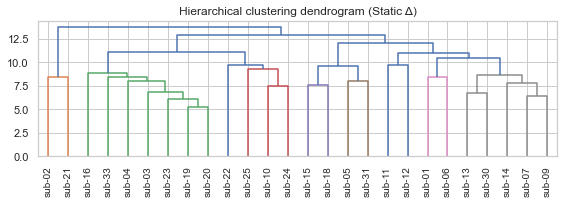

In [49]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

Z = linkage(Xz, method="ward")
cl_h = fcluster(Z, t=2, criterion="maxclust") - 1  # -> 0/1

# align
cm0 = confusion_matrix(y_true, cl_h)
cm1 = confusion_matrix(y_true, 1 - cl_h)
cl_h_aligned = (1 - cl_h) if np.trace(cm1) > np.trace(cm0) else cl_h

ari_h = adjusted_rand_score(y_true, cl_h_aligned)
print("Hierarchical ARI:", ari_h)

plt.figure(figsize=(8,3))
dendrogram(Z, labels=df.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical clustering dendrogram (Static Δ)")
plt.tight_layout()
plt.show()

In [50]:
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, image, plotting

ROOT = Path("/Users/onilarasanjala/Desktop/TSeme/CogNeuSci/CodeData/NewPCA")

COMP_NII = ROOT / "group_pca_K20_components.nii.gz"
MASK_NII = ROOT / "mask_from_first_run.nii.gz"

TOP_PCS = [2, 5, 6, 7, 10, 18, 19]   # your chosen PCs
pc_indices = [pc - 1 for pc in TOP_PCS]

comp_img = nib.load(str(COMP_NII))
mask_img = nib.load(str(MASK_NII))

comp_data = comp_img.get_fdata(dtype=np.float32)   # (X,Y,Z,K)
mask_data = mask_img.get_fdata().astype(bool)

print("components shape:", comp_data.shape)
print("mask voxels:", mask_data.sum())

components shape: (91, 109, 91, 20)
mask voxels: 892725


In [51]:
def zscore_map(vol3d, mask):
    x = vol3d[mask].astype(np.float64)
    mu, sd = x.mean(), x.std()
    if sd == 0: sd = 1.0
    z = (vol3d.astype(np.float64) - mu) / sd
    z[~mask] = 0
    return z.astype(np.float32)

pc_imgs = {}
for pc, idx in zip(TOP_PCS, pc_indices):
    zvol = zscore_map(comp_data[..., idx], mask_data)
    pc_imgs[pc] = nib.Nifti1Image(zvol, affine=comp_img.affine)

list(pc_imgs.keys())

[2, 5, 6, 7, 10, 18, 19]

In [52]:
yeo = datasets.fetch_atlas_yeo_2011()
yeo7_img = nib.load(yeo.thick_7)

def yeo7_fingerprint(pc_img, mask_img, yeo7_img):
    yeo_rs = image.resample_to_img(
        yeo7_img, pc_img,
        interpolation="nearest",
        force_resample=True,
        copy_header=True
    )
    z = pc_img.get_fdata().astype(np.float64)
    m = mask_img.get_fdata().astype(bool)
    y = yeo_rs.get_fdata().astype(np.int16)

    z = z[m]
    y = y[m]
    good = np.isfinite(z)
    z, y = z[good], y[good]

    fp = []
    for lab in range(1, 8):
        sel = (y == lab)
        if sel.sum() < 50:
            fp.append(np.nan)
        else:
            fp.append(np.mean(np.abs(z[sel])))
    return np.array(fp, dtype=np.float64)

yeo7_names = ["Visual","Somatomotor","DorsalAttn","VentralAttn/Salience","Limbic","Frontoparietal/Control","DefaultMode"]

pc_fp = {}
for pc in TOP_PCS:
    pc_fp[pc] = yeo7_fingerprint(pc_imgs[pc], mask_img, yeo7_img)

fp_df = pd.DataFrame(pc_fp, index=yeo7_names).T
fp_df

[get_dataset_dir] Dataset found in /Users/onilarasanjala/nilearn_data/yeo_2011

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed